In [1]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.device('/gpu:0')
RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
a = pd.DataFrame(X_train)
print(a)

       0    1         2         3         4         5         6         7   \
0     0.0  0.0 -0.198347 -0.479339 -0.454545 -0.834711 -0.702479 -0.909091   
1     0.0  0.0 -0.338028 -0.246479 -0.542253 -0.556338 -0.584507 -0.859155   
2     0.0  0.0 -0.289855 -0.166667 -0.471014 -0.507246 -0.434783 -0.876812   
3     0.0  0.0  0.086735 -0.219388  0.173469 -0.367347  0.214286 -0.443878   
4     0.0  0.0 -0.154639  0.154639 -0.376289  0.242268 -0.572165  0.252577   
...   ...  ...       ...       ...       ...       ...       ...       ...   
3643  0.0  0.0 -0.248092 -0.026718 -0.442748 -0.087786 -0.587786 -0.133588   
3644  0.0  0.0 -0.200000 -0.073171 -0.356098 -0.224390 -0.478049 -0.341463   
3645  0.0  0.0 -0.040000  0.350000 -0.060000  0.630000 -0.190000  0.840000   
3646  0.0  0.0 -0.040000 -0.305000 -0.130000 -0.525000 -0.170000 -0.720000   
3647  0.0  0.0  0.233533  0.071856  0.491018  0.077844  0.706587  0.083832   

            8         9   ...        32        33        34    

In [8]:
a.groupby(0).size()


0
0.0    3648
dtype: int64

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [12]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
28/29 [===========================>..] - ETA: 0s - loss: 1.5467 - accuracy: 0.3089 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
29/29 [==============================] - 1s 13ms/step - loss: 1.5447 - accuracy: 0.3084 - val_loss: 1.4419 - val_accuracy: 0.3887
Epoch 2/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.5204 - accuracy: 0.3281
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
29/29 [==============================] - 0s 4ms/step - loss: 1.4235 - accuracy: 0.3596 - val_loss: 1.3477 - val_accuracy: 0.3936
Epoch 3/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.3811 - accuracy: 0.4141
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
29/29 [==============================] - 0s 3ms/step - loss: 1.3528 - accuracy: 0.3947 - val_loss: 1.2669 - val_accuracy: 0.4380
Epoch 4/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.3081 - accuracy: 0.4375

KeyboardInterrupt: 

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/10 [==>...........................] - ETA: 0s - loss: 0.2959 - accuracy: 0.9141

10/10 [==============================] - 0s 12ms/step - loss: 0.1979 - accuracy: 0.9671


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 252ms/step
[7.2690011e-03 9.7780788e-01 1.4915321e-02 2.2594752e-10 7.8389476e-06]
1


# Confusion matrix

39/39 [==============================] - 0s 3ms/step


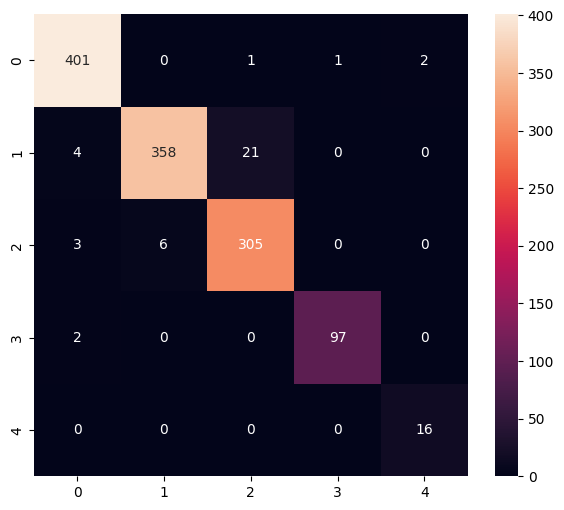

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       405
           1       0.98      0.93      0.96       383
           2       0.93      0.97      0.95       314
           3       0.99      0.98      0.98        99
           4       0.89      1.00      0.94        16

    accuracy                           0.97      1217
   macro avg       0.95      0.98      0.96      1217
weighted avg       0.97      0.97      0.97      1217



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp9zk9b1_r\assets


6588

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.2690081e-03 9.7780788e-01 1.4915321e-02 2.2594752e-10 7.8389394e-06]
1
